In [1]:
import pandas as pd
import json
import  tarfile
import bz2
import os
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk import agreement
import statsmodels.formula.api as smf
sns.set_style('whitegrid')
%matplotlib inline
import random
import math

import multiprocessing
import json
import os
import re
import datetime
import time
import pprint
from datetime import datetime
from datetime import timedelta
import pytz
import glob
from random import sample
import pickle
from datetime import date, timedelta

In [2]:
files = []
for i in range(40):
    files.append("derived_dataset_threads/lengths_derived_dataset_batch_"+str(i+1)+".parquet")

In [3]:
allowed_languages = ['ar',
 'nl',
 'en',
 'et',
 'fr',
 'de',
 'ht',
 'hi',
 'in',
 'it',
 'fa',
 'pl',
 'pt',
 'ru',
 'es',
 'sv',
 'tl',
 'th',
 'tr',
 'ur']

allowed_sources = ['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
    '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
    '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
    '<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M2)</a>',
    '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>']

In [4]:
def process_batch(file):
    df = pd.read_parquet(file)
    df = df.loc[df['lang'].isin(allowed_languages)]
    df = df.loc[df['source'].isin(allowed_sources)]
    
    df['all_lang'] = ['1']*len(df)
    df_stats = df.groupby('all_lang').apply(lambda x: pd.Series({
            'histogram_thread_lengths_2017': x.loc[(x['created_at'].dt.year == 2017) & (x['created_at'].dt.month < 11)]['n'].value_counts(dropna = False),
            'histogram_thread_lengths_2019': x.loc[(x['created_at'].dt.year == 2019) & (x['created_at'].dt.month < 11)]['n'].value_counts(dropna = False),
            'histogram_thread_positions_2017': x.loc[(x['created_at'].dt.year == 2017) & (x['created_at'].dt.month < 11)]['m'].value_counts(),
            'histogram_thread_positions_2019': x.loc[(x['created_at'].dt.year == 2019) & (x['created_at'].dt.month < 11)]['m'].value_counts()
            }))
    
    return df_stats

In [5]:
p = multiprocessing.Pool(10)
print('Parallelized on number of cores:',multiprocessing.cpu_count())

start = time.time()

outputs = p.map(process_batch, files)

p.close()
p.join()

end = time.time()
elapsed = end - start

print('Elapsed time:',time.strftime("%H:%M:%S", time.gmtime(elapsed)))

Parallelized on number of cores: 48
Elapsed time: 00:08:51


In [27]:
outputs[0]

,histogram_thread_lengths_2017,histogram_thread_lengths_2019,histogram_thread_positions_2017,histogram_thread_positions_2019
all_lang,,,,
1,NaN 13019831 2.0 2406 10.0 ...,"Series([], Name: n, dtype: int64)",1.0 2029 2.0 940 10.0 389 3.0 ...,"Series([], Name: m, dtype: int64)"


In [28]:
hist_before_regular = []
hist_after_regular = []


for cnt,item in enumerate(outputs):
    if cnt==0:
        hist_2017 = item.loc['1']['histogram_thread_lengths_2017']
        hist_2019 = item.loc['1']['histogram_thread_lengths_2019']
        pos_hist_2017 = item.loc['1']['histogram_thread_positions_2017']
        pos_hist_2019 = item.loc['1']['histogram_thread_positions_2019']
    else:
        hist_2017 = hist_2017.add(item.loc['1']['histogram_thread_lengths_2017'],fill_value=0)
        hist_2019 = hist_2019.add(item.loc['1']['histogram_thread_lengths_2019'],fill_value=0)
        pos_hist_2017 = pos_hist_2017.add(item.loc['1']['histogram_thread_positions_2017'],fill_value=0)
        pos_hist_2019 = pos_hist_2019.add(item.loc['1']['histogram_thread_positions_2019'],fill_value=0)
    

In [29]:
h1 = np.array([hist_2017.values[-1]] + [hist_2017[i] if i in hist_2017.index else 0 for i in range(2,50)])
h2 = np.array([hist_2019.values[-1]] + [hist_2019[i] if i in hist_2019.index else 0 for i in range(2,50)])

Text(0, 0.5, 'number of observed paginated tweets')

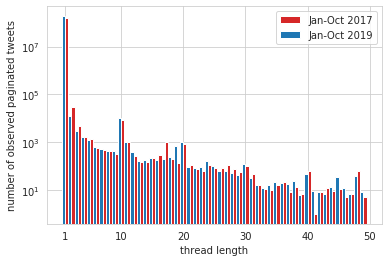

In [32]:
#number log

width = 0.5
plt.bar(np.array(range(1,50)) + 0.5*width,h1, width, color = 'tab:red', label = 'Jan-Oct 2017')
plt.bar(np.array(range(1,50)) - 0.5*width,h2, width, color = 'tab:blue', label = 'Jan-Oct 2019')

plt.xticks([1]+list(range(10,51,10)));

#plt.xlim([0,30])
plt.yscale('log')

#plt.ylim([0.001,0.9])

plt.legend()

plt.xlabel('thread length')

plt.ylabel('number of observed paginated tweets')

## Estimating number of threads of length k

In [34]:
1/np.array(range(1,50))

array([1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
       0.16666667, 0.14285714, 0.125     , 0.11111111, 0.1       ,
       0.09090909, 0.08333333, 0.07692308, 0.07142857, 0.06666667,
       0.0625    , 0.05882353, 0.05555556, 0.05263158, 0.05      ,
       0.04761905, 0.04545455, 0.04347826, 0.04166667, 0.04      ,
       0.03846154, 0.03703704, 0.03571429, 0.03448276, 0.03333333,
       0.03225806, 0.03125   , 0.03030303, 0.02941176, 0.02857143,
       0.02777778, 0.02702703, 0.02631579, 0.02564103, 0.025     ,
       0.02439024, 0.02380952, 0.02325581, 0.02272727, 0.02222222,
       0.02173913, 0.0212766 , 0.02083333, 0.02040816])

Text(0, 0.5, 'number of observed paginated tweets')

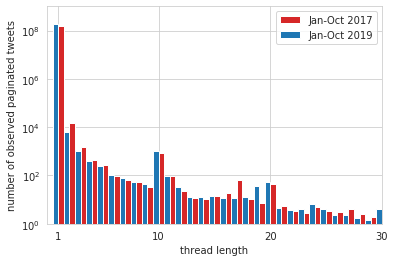

In [49]:
#number log

width = 0.5
plt.bar(np.array(range(1,50)) + 0.5*width,1/np.array(range(1,50))*h1, width, color = 'tab:red', label = 'Jan-Oct 2017')
plt.bar(np.array(range(1,50)) - 0.5*width,1/np.array(range(1,50))*h2, width, color = 'tab:blue', label = 'Jan-Oct 2019')

plt.xticks([1]+list(range(10,51,10)));

plt.xlim([0,30])
plt.yscale('log')

plt.ylim([1,1000000000])

plt.legend()

plt.xlabel('thread length')

plt.ylabel('number of observed paginated tweets')

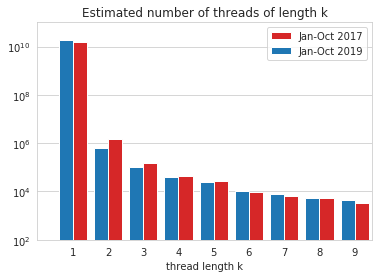

In [134]:
#number log

fig, axes = plt.subplots(1,1, figsize= (6,4))

width = 0.4
plt.bar(np.array(range(1,50)) + 0.5*width,100*1/np.array(range(1,50))*h1, width, color = 'tab:red', label = 'Jan-Oct 2017')
plt.bar(np.array(range(1,50)) - 0.5*width,100*1/np.array(range(1,50))*h2, width, color = 'tab:blue', label = 'Jan-Oct 2019')

plt.xticks(list(range(1,10)));

plt.xlim([0,30.5])
plt.yscale('log', basey=10)

plt.ylim([100,100000000000])

plt.xlim([0,9.5])

plt.legend()

plt.xlabel('thread length k')


plt.title('Estimated number of threads of length k')

plt.gca().xaxis.grid(False) 
#plt.yticks([np.exp2(i) for i in range(7,34)]);



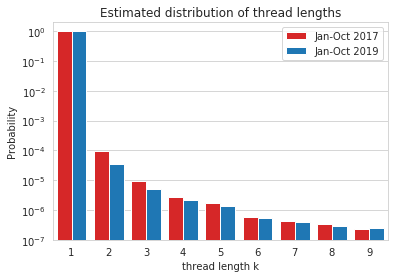

In [156]:
#number log

fig, axes = plt.subplots(1,1, figsize= (6,4))

width = 0.4
plt.bar(np.array(range(1,50)) - 0.5*width,(100*1/np.array(range(1,50))*h1)/sum(100*1/np.array(range(1,50))*h1) , width, color = 'tab:red', label = 'Jan-Oct 2017')
plt.bar(np.array(range(1,50)) + 0.5*width,(100*1/np.array(range(1,50))*h2)/sum(100*1/np.array(range(1,50))*h2) , width, color = 'tab:blue', label = 'Jan-Oct 2019')

plt.xticks(list(range(1,10)));

plt.xlim([0.5,9.5])
plt.yscale('log', basey=10)

plt.ylim([0.0000001,2])

plt.legend()

plt.xlabel('thread length k')


plt.title('Estimated distribution of thread lengths')
plt.ylabel('Probability')

plt.gca().xaxis.grid(False) 
#plt.yticks([np.exp2(i) for i in range(7,34)]);

plt.savefig("fig_threads.pdf", bbox_inches='tight')

In [155]:
#null model

In [150]:
[1]+list((((100*1/np.array(range(1,50))*h1)/sum(100*1/np.array(range(1,50))*h1))[:9] /2 )[1:])

[1,
 4.705926380304369e-05,
 4.8603859921886445e-06,
 1.3707824030185393e-06,
 8.771727769140804e-07,
 2.943103409047972e-07,
 2.0976466843990986e-07,
 1.6914847038414298e-07,
 1.1161044328998349e-07]

Text(0.5, 1.0, 'Estimated probability of a thread of length k')

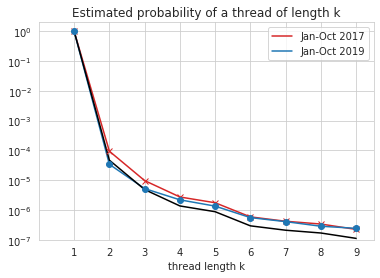

In [146]:
#number log

fig, axes = plt.subplots(1,1, figsize= (6,4))

width = 0.4


plt.plot(np.array(range(1,10)),((100*1/np.array(range(1,50))*h1)/sum(100*1/np.array(range(1,50))*h1))[:9] , color = 'tab:red', label = 'Jan-Oct 2017')
plt.plot(np.array(range(1,10)),((100*1/np.array(range(1,50))*h2)/sum(100*1/np.array(range(1,50))*h2))[:9] ,  color = 'tab:blue', label = 'Jan-Oct 2019')


plt.plot(np.array(range(1,10)),[1]+list((((100*1/np.array(range(1,50))*h1)/sum(100*1/np.array(range(1,50))*h1))[:9] /2 )[1:]), color = 'black')
plt.legend()

plt.plot(np.array(range(1,10)),((100*1/np.array(range(1,50))*h1)/sum(100*1/np.array(range(1,50))*h1))[:9] , color = 'tab:red', label = 'Jan-Oct 2017', marker = 'x', linestyle = 'none')
plt.plot(np.array(range(1,10)),((100*1/np.array(range(1,50))*h2)/sum(100*1/np.array(range(1,50))*h2))[:9] ,  color = 'tab:blue', label = 'Jan-Oct 2019', marker = 'o', linestyle = 'none')



plt.xticks(list(range(1,10)));

plt.xlim([0,9.5])
plt.yscale('log', basey=10)

plt.ylim([0.0000001,2])


plt.xlabel('thread length k')


plt.title('Estimated probability of a thread of length k')


#plt.yticks([np.exp2(i) for i in range(7,34)]);



In [62]:
#problem: different total number of tweets (sum of 
#blue is slightly greater because twitter is growing)

In [63]:
#normalized